## **Importing libraries and data**

In [1]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.model_selection import GroupKFold

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Load ADS using name and path

load_ads = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Master_Dataset/OMS_IPL_V1.csv', index_col=0)
load_ads = load_ads[load_ads.TR>0]

# Dropping the rows with NA values in Slope_ROC_outages & Slope_outages
load_ads.dropna(subset=['Slope_ROC_outages', 'Slope_outages'],inplace=True)
load_ads.reset_index(drop=True, inplace=True)

/opt/conda/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

In [4]:
# converting data type of CIRCT_ID & SUBST_ID to integer as it will passed as cxategorical column
load_ads['CIRCT_ID'] = load_ads['CIRCT_ID'].astype(int)
load_ads['SUBST_ID'] = load_ads['SUBST_ID'].astype(int)

# create year columns
load_ads['CREATION_DATETIME'] = pd.to_datetime(load_ads['CREATION_DATETIME'], errors='coerce')
load_ads['Year'] = load_ads['CREATION_DATETIME'].dt.year

# subset for last 5 years data 
load_ads_v1 = load_ads[(load_ads.Year>2014) & ((load_ads.Year<2020))]
load_ads_v1.reset_index(drop=True, inplace=True)
print(load_ads_v1.shape)

#### **Load Feature Importance Table using CatBoost**

In [8]:
catboost = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Repredictions/Model/IPL_TTR_Catboost_12092020.csv')
final_features = list(catboost.Features)

#### **Group K fold Split using sklearn**

In [9]:
X = load_ads_v1
y = load_ads_v1['TR']

groups = load_ads_v1['OUTAGE_ID']
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(X, y, groups)

5

In [10]:
# creating variable with having only categorical features index
categorical_features_indices = np.where((X[final_features].dtypes != np.int) & (X[final_features].dtypes != np.float))[0];
print(categorical_features_indices)

[12 13 15 27 32 33 35 37]


In [11]:
# adding Substation id and Circuit id as categorical feature
arr1 = np.array([6, 11])
categorical_features_indices = np.append(arr1, categorical_features_indices)
print(categorical_features_indices)

[ 6 11 12 13 15 27 32 33 35 37]


#### **Randomized Search using CatBoost**

In [12]:
# parameter grid for randomized search 
grid_params = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 5)],
               'depth': [int(x) for x in np.linspace(3, 10, num = 5)],
               'l2_leaf_reg': [3,4,5,6],
               'leaf_estimation_iterations': [1,2,3,4]}

grid_params

{'n_estimators': [1000, 2000, 3000, 4000, 5000],
 'depth': [3, 4, 6, 8, 10],
 'l2_leaf_reg': [3, 4, 5, 6],
 'leaf_estimation_iterations': [1, 2, 3, 4]}

In [ ]:
# model declaration
cat_ran = CatBoostRegressor(silent=True, cat_features=categorical_features_indices, early_stopping_rounds=50)

# Randomized search using CatBoost Randmized Serch Implementation
randomized_search_result = cat_ran.randomized_search(grid_params, X=X[final_features], y=y, n_iter=100, cv=group_kfold.split(X, y, groups), verbose=True)

Stopped by overfitting detector  (50 iterations wait)

bestTest = 366.4821562
bestIteration = 567

0:	loss: 366.4821562	best: 366.4821562 (0)	total: 3m 56s	remaining: 6h 30m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 368.4590974
bestIteration = 522

1:	loss: 368.4590974	best: 366.4821562 (0)	total: 7m 41s	remaining: 6h 16m 57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 368.4590974
bestIteration = 522

2:	loss: 368.4590974	best: 366.4821562 (0)	total: 11m 26s	remaining: 6h 10m 8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 366.4821562
bestIteration = 567

3:	loss: 366.4821562	best: 366.4821562 (0)	total: 13m 6s	remaining: 5h 14m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 361.8681708
bestIteration = 319

4:	loss: 361.8681708	best: 361.8681708 (4)	total: 13m 43s	remaining: 4h 20m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 366.302876
bestIteration = 341

5:	loss: 36

In [29]:
# randomized_search_result
df_results = pd.DataFrame(randomized_search_result.get('cv_results'))
df_results.head()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,634.127918,0.361326,633.931096,0.179364
1,1,621.474381,0.452094,621.105583,0.238404
2,2,609.153209,0.462052,608.720170,0.331942
3,3,597.424155,0.628603,596.884058,0.475272
4,4,586.246076,0.727187,585.420937,0.500653


In [30]:
randomized_search_result.get('params')

{'leaf_estimation_iterations': 1,
 'depth': 6,
 'l2_leaf_reg': 5,
 'iterations': 4000}

#### **Saving Model Object**

In [32]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/IPL_TTR_Catboost_12102020.pkl', 'wb') as f:
    pickle.dump(cat_ran, f)

#### **2020 out of Sample Validation**

In [57]:
from scipy.stats import linregress

# load 2020 dataset
df_ads_2020 = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_2020_11162020.csv')
df_ads_2020['Time_Since_Outage'] = 60

# add features
def feature_add(group):
    group = group.reset_index(drop = True)
    x = [group.Outages_in_last_1hr[0],group.Outages_in_last_2hr[0],group.Outages_in_last_3hr[0],group.Outages_in_last_4hr[0],group.Outages_in_last_5hr[0]
        ,group.Outages_in_last_6hr[0],group.Outages_in_last_7hr[0],group.Outages_in_last_8hr[0],group.Outages_in_last_9hr[0],group.Outages_in_last_10hr[0]]
    y = [1,2,3,4,5,6,7,8,9,10]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    group['Slope_outages'] = slope
    
    ROC = [abs(group.Outages_in_last_1hr[0] - group.Outages_in_last_2hr[0]),abs(group.Outages_in_last_2hr[0] - group.Outages_in_last_3hr[0]),
           abs(group.Outages_in_last_3hr[0] - group.Outages_in_last_4hr[0]),abs(group.Outages_in_last_4hr[0] - group.Outages_in_last_5hr[0]),
           abs(group.Outages_in_last_5hr[0] - group.Outages_in_last_6hr[0]),abs(group.Outages_in_last_6hr[0] - group.Outages_in_last_7hr[0]),
           abs(group.Outages_in_last_7hr[0] - group.Outages_in_last_8hr[0]),abs(group.Outages_in_last_8hr[0] - group.Outages_in_last_9hr[0]),
           abs(group.Outages_in_last_9hr[0] - group.Outages_in_last_10hr[0])]
    y = [1,2,3,4,5,6,7,8,9]
    slope, intercept, r_value, p_value, std_err = linregress(ROC, y)
    group['Slope_ROC_outages'] = slope
    
    group['max_ROC_outages'] = max(ROC)
    group['max_index_ROC'] = 1+ROC.index(max(ROC))    
    group['weight_ROC'] = group['max_ROC_outages'] * group['max_index_ROC']*0.1
    return group

In [64]:
df_ads_2020 = df_ads_2020.groupby(['OUTAGE_ID'], as_index = False).apply(feature_add).reset_index(drop = True)
df_ads_2020 = df_ads_2020.dropna(axis=0, subset=['Slope_outages', 'Slope_ROC_outages'])
df_ads_2020 = df_ads_2020[df_ads_2020.TTR>60]
df_ads_2020 = df_ads_2020[df_ads_2020.TTR<5000]

In [72]:
storm_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE']
storm_result_df = pd.DataFrame(columns=storm_col)
storm_test_list = pd.DataFrame() 
i=0

In [73]:
df_ads_2020['CIRCT_ID'] = df_ads_2020['CIRCT_ID'].astype(int)
df_ads_2020['SUBST_ID'] = df_ads_2020['SUBST_ID'].astype(int)

In [74]:
X = df_ads_2020[final_features]
y = df_ads_2020.TTR

y_test_pred = cat_ran.predict(X)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)

data_test = pd.DataFrame({'Model':'CatBoost2020', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['CatBoost2020', mse_test, rmse_test, mae_test, mape_test]
i = i + 1

In [75]:
storm_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE
0,CatBoost2020,122714.016671,350.305605,218.613505,123.670989


/opt/conda/anaconda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


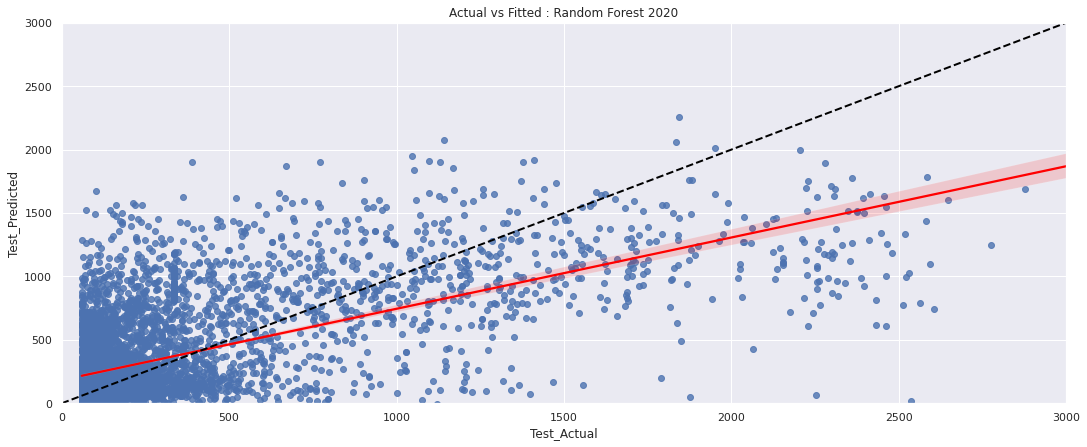

In [76]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=storm_test_list[storm_test_list.Model=='CatBoost2020'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest 2020')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)